# Carga de Datos

Haremos carga desde objetos binarios así como desde arxhivos particionados por columnas, haciendo uso de la particularidad de ser una BBDD columnar.

## Carga Desde Binarios

In [ ]:
\ts historical: get `:Data/DataWarehouse/Tables/historical

In [ ]:
\ts resume_etf: get `:Data/DataWarehouse/Tables/resume_etf

## Carga Desde Tablas Splayed

In [ ]:
\ts load `:Data/DataWarehouse/Tables/historicalSplayed/sym;
\ts historicalS: get `:Data/DataWarehouse/Tables/historicalSplayed/historical

In [ ]:
\ts load `:Data/DataWarehouse/Tables/resume_etfSplayed/sym;
\ts resume_etfS: get `:Data/DataWarehouse/Tables/resume_etfSplayed/resume_etf

# Modelo de Estrategia de Inversión en ETFs

En este apartado realizaremos el soporte para la elección de ETF.

En el anterior Notebook hemos realizado todos los cálculos necesarios para ahora poder selecionar y evaluar los ETFs, en especial sus volatilidades, drawdowns y, por tanto, sus riesgos.



## Generación de nuevas tablas para guardar los Momentos a estudiar

Se realizará un estudio sobre los históricos con un claro objetivo: El mercado es cíclico y repetitivo, por lo que se buscará encontrar los valores que tenían los momentos claves a tener grandes caídas o grandes subidas.


In [ ]:
etfs: exec ticker from resume_etf

Para ello se tratará de agrupar y visualizar los datos para responder a estas dos preguntas:
> - ¿Qué valores tenía el drawdowns acumulados o las volatilidades cuando se alcanza el **25% o más de PÉRDIDAS acumuladas**?
> - ¿Qué valores tenía el drawdowns acumulados o las volatilidades cuando se alcanza el **25% o más de BENEFICIOS acumulados**?

In [ ]:
table_losses: ([ticker:`$();date:`date$();elem:`$()]nav_value:`float$();vol5y:`float$();
                vol3y:`float$(); vol1y:`float$(); vol6m:`float$(); vol3m:`float$();
                drawdown5y:`float$(); drawdown3y:`float$(); drawdown1y:`float$())

table_profits: ([ticker:`$();date:`date$();elem:`$()]nav_value:`float$();vol5y:`float$();
                vol3y:`float$(); vol1y:`float$(); vol6m:`float$(); vol3m:`float$();
                drawdown5y:`float$(); drawdown3y:`float$(); drawdown1y:`float$())

En nuestro caso estudiaremos a partir del 20%, pero se podría modificar ese %.

Crearemos 2 tablas y 2 funciones, muy parecidas. En ambos casos tenemos el valor elem, donde guardaremos un símbolo que significara:
> - ***`p5y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 5 años desde hasta día guardado.
> - ***`p3y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 3 años desde hasta día guardado.
> - ***`p1y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 1 año desde hasta día guardado.
> - ***`p6m***: Hay una ganancia/pérdida acumulada del 20% en los últimos 6 meses desde hasta día guardado.
> - ***`p3m***: Hay una ganancia/pérdida acumulada del 20% en los últimos 3 meses desde hasta día guardado.

Para ello creamos un diccionario que servirá para mapear el simbolo que guardar en el tabla. Además las columnas se usarán para el filtrado y pasarse en el iterador en la variable *values_perf*.

In [ ]:
elMap: `performance_5y`performance_3y`performance_1y`performance_6m`performance_3m
        ! (`p5y; `p3y; `p1y; `p6m; `p3m);
values_perf: cols elMap;

In [ ]:
calc_losses_v1:{
    t: select from historical where @[historical;x] < -0.25;
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value, vol5y:daily_5yvol, 
        vol3y:daily_3yvol, vol1y:daily_1yvol, vol6m:daily_6mvol, vol3m:daily_3mvol, 
        drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y
        from t where @[t;x] <> 0n;
    upsert[`table_losses;a];
 }

calc_profits_v1:{
    t: select from historical where @[historical;x] > 0.25;
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value, vol5y:daily_5yvol, 
        vol3y:daily_3yvol, vol1y:daily_1yvol, vol6m:daily_6mvol, vol3m:daily_3mvol, 
        drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y
      from t where @[t;x] <> 0n;
    upsert[`table_profits;a];
 }

Esto nos podría permitir generar datos de la siguiente manera:

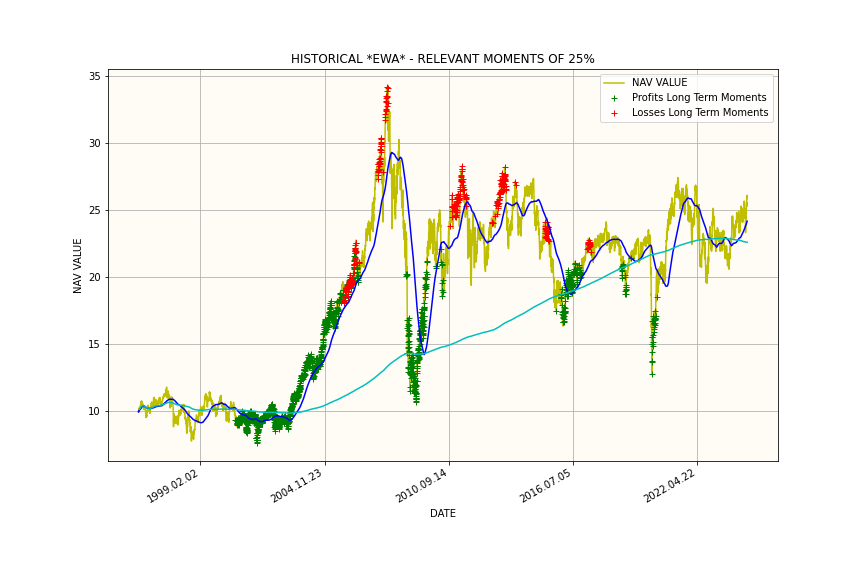

Sin embargo, no nos interesa. Nos interesa que se cumplan dos elementos más: 

> - Que los datos de **señales de compra** siempre se encuentren por debajo de la SMA200 mensual.
> - Que los datos de **señales de venta** siempre se encuentren por encima de la SMA200 mensual.

Para ello usaremos las nuevas funciones usando la tabla historical modificada añadiendo la columna m200sma2(esta tiene valores en SMA200 diarios en vez de solo en el último día del mes, lo que nos permite filtrar los datos):

In [ ]:
// Necesaria para hacer los filtrados por encima/debajo de la monthly200sma
historical: `ticker`date xasc historical
temp2: select last date, last nav_value by ticker, m:`month$date from historical
temp2: update m200sma2: mavg[200; nav_value] by ticker from temp2;
temp2: select distinct ticker, m, m200sma2 from temp2
historical: update m:`month$date from historical
historical: aj[`ticker`m; historical; temp2]
historical: delete m from historical

In [ ]:
calc_losses_v2:{
    t: select from historical where @[historical;x] < -0.25, nav_value >= m200sma2;
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value, vol5y:daily_5yvol, 
        vol3y:daily_3yvol, vol1y:daily_1yvol, vol6m:daily_6mvol, vol3m:daily_3mvol, 
        drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y
        from t where @[t;x] <> 0n;
    upsert[`table_losses;a];
 }

calc_profits_v2:{
    t: select from historical where @[historical;x] > 0.25, nav_value < m200sma2;
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value, vol5y:daily_5yvol, 
        vol3y:daily_3yvol, vol1y:daily_1yvol, vol6m:daily_6mvol, vol3m:daily_3mvol, 
        drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y
      from t where @[t;x] <> 0n;
    upsert[`table_profits;a];
 }

Con esta nueva versión, nos saldrían gráficos de esta manera, pareciendose más al objetivo final:
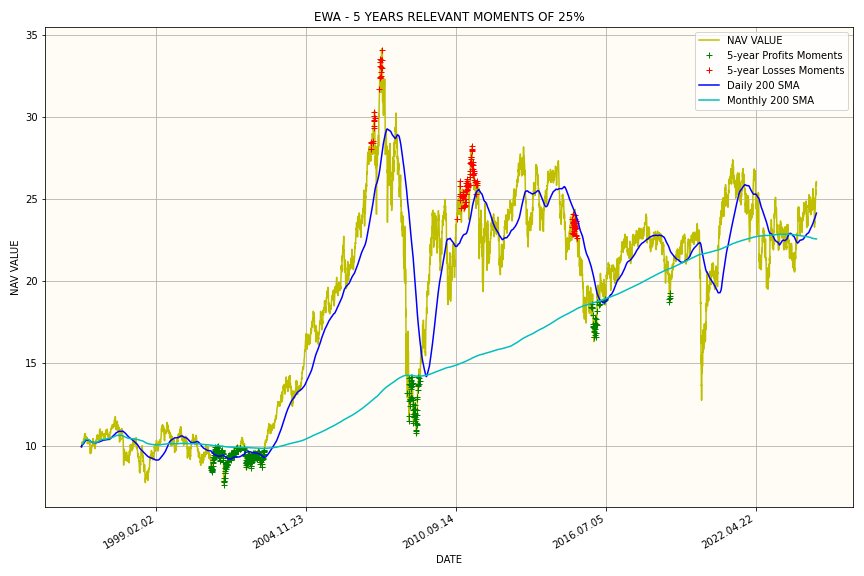

In [ ]:
{calc_losses_v2[x]} each values_perf;
{calc_profits_v2[x]} each values_perf;

## Agrupación por Características de los ETFs

Para llevar a cabo todo el trabajo de estudio y visualización de los datos, también nos interesa saber que datos tenemos, como vamos a agrupar los datos.

Por ello, veremos las posibles divisiones que podemos hacer, así como el número de ETFs de cada división.

In [ ]:
select num_etf: count equity_class by equity_class,market,region from resume_etf
select num_etf: count equity_class by equity_class,region from resume_etf
select num_etf: count equity_class by equity_class,market from resume_etf

En esa primera instancia distinguiendo entre las 3 tipologías, no vamos a conseguir información y agrupaciones con datos suficientes para sacar conclusiones en claro.

In [ ]:
select num_etf: count equity_class by equity_class from resume_etf
select num_etf: count market by market from resume_etf
select num_etf: count region by region from resume_etf

Después de ver las distintas opciones, tomamos la decisión de realizar el estudio haciendo una partición sobre los tipos de **renta variable**, esa equity class. 

Por tanto, usaremos el siguiente listado de ETFs para estudiar de maneras agrupadas:

In [ ]:
all_cap_etf: exec ticker from resume_etf where equity_class=`$"All Cap"
large_cap_etf: exec ticker from resume_etf where equity_class=`$"Large Cap"
largemid_cap_etf: exec ticker from resume_etf where equity_class=`$"Large/Mid Cap"
mid_cap_etf: exec ticker from resume_etf where equity_class=`$"Mid Cap"
small_cap_etf: exec ticker from resume_etf where equity_class=`$"Small Cap"

# Visualización de Datos


Los gráficos cargados anteriormente son de elboración propia y gran parte del ejercicio que haremos en este Notebook.

Para este apartado usaremos las sinergias entre KDB+/Q y Python, que al usar Jupyter Notebook se nos facilita aún más esa integración.

Usaremos el módulo y biblioteca por excelencia para esta representación gráfica en Python, [Matplotlib](https://matplotlib.org/stable/).

En caso de no ejecutar el anterior notebook, también reinstalaremos las dependencias.

En primer lugar cargaremos en las variables **plt** y **mdates** los módulos de Python más usados para la representación gráfica y manipulación de fechas.

In [ ]:
\l p.q

system "pip install -r requirements.txt"

plt:.p.import[`matplotlib;`:pyplot]
mdates:.p.import[`matplotlib;`:dates]

Cargaremos la variable de **etfs**, como la lista de todos los etfs disponibles, de cara a ejecutar funciones a todos los etfs.

Posteriormente usaremos otras consultas para filtrar los etfs según características.

Para la generación de gráficos, estudios de momentos de los históricos y otros fines, haremos uso del módulo de *QFunctions/**queries.q***, donde se encuentra una rista importante de queries según el valor a calcular. Para ello usaremos la carga a este notebook como un script.

En KDB+/Q no tenemos manera de ver en la carga las funciones que se carga en la sesión, por lo que usaremos una variable y veremos las diferencias entre las disponibles previa y posterior a la carga.

In [ ]:
show initialSymbols: string each key `.

// Cargar las funciones donde están guardadas las Queries
\l QFunctions/queries.q

show loadedSymbols: string each key `.

## Generación de Gráficos 

Al igual que las queries, para representar esa información usaremos el módulo de *QFunctions/**graphics.q***, que usa las funciones de queries para representar las gráficas, ademas del uso de las bibliotecas de dates y matplotlib de Python, como antes hemos comentado. 

In [ ]:
/
    Carga las funciones desarroladas donde está el código para generar gráficos con Matplotlib,
    pasándole datos a través de las queries desarroladas
\
\l QFunctions/graphics.q

Ahora podremos estudiar elementos de los etfs, generando los gráficos. Cómo hemos indicado, podemos hacerlo de todos los ETFs usando la variable etf en un iterador o generar una nueva lista de ETFs.

**Por ejemplo:**

In [ ]:
{in_outflow_g_F[x;2020.01.01]} each etfs;
{daily_vol[x]} each (exec ticker from resume_etf where region=`$"Europe");

### Generación de Históricos

In [ ]:
{historical_g[x]} each small_cap_etf;

Todas las funciones están creadas para generar estas imágenes y guardarlas en diferentes puntos del DataWarehouse según lo establecido cómo conveniente.

En este caso se guardan en *Data/DataWarehouse/Images/Hist/*, por cada ETF.

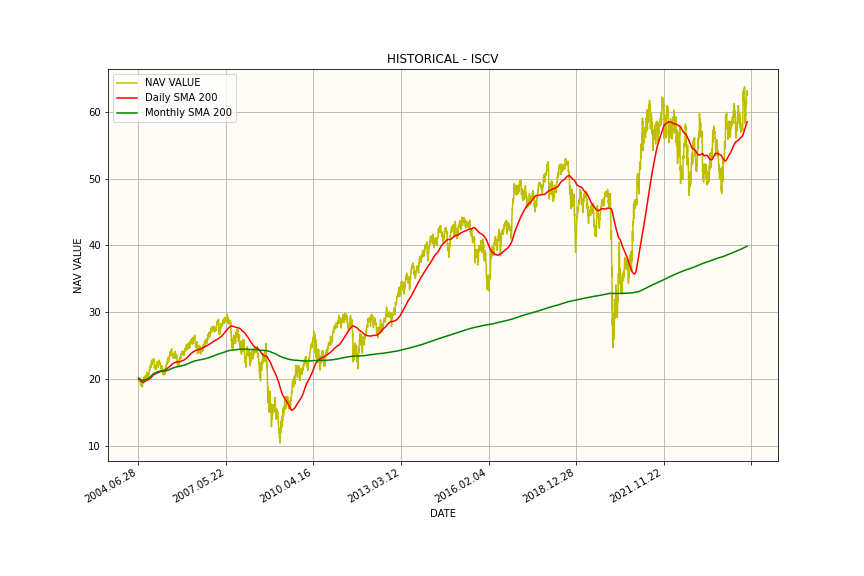

### Generación de Volúmes de Emisión y Recompra: Inflows/Outflows mensuales

In [ ]:
{in_outflow_g[x]} each all_cap_etf;

En este caso se guardan en la ruta de *Data/DataWarehouse/Images/Inflow-Outflow/*, por cada ETF.

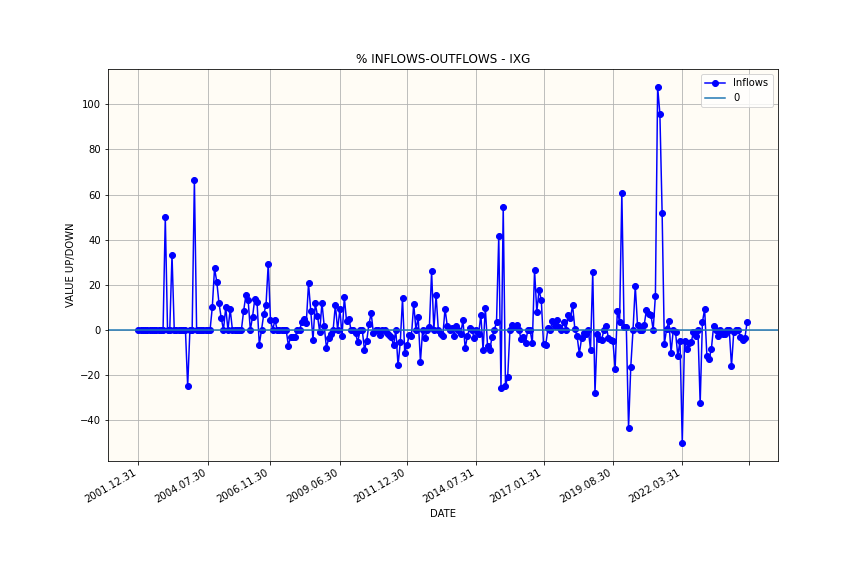

### Generación de Gráficos de Daily Returns

In [ ]:
{daily_ret[x]} each (`EWA;`EWJ;`ISCG);

En este caso los datos se guardan en *Data/DataWarehouse/Images/Analytics/DailyReturns/...-dailyreturns*, por cada ETF.
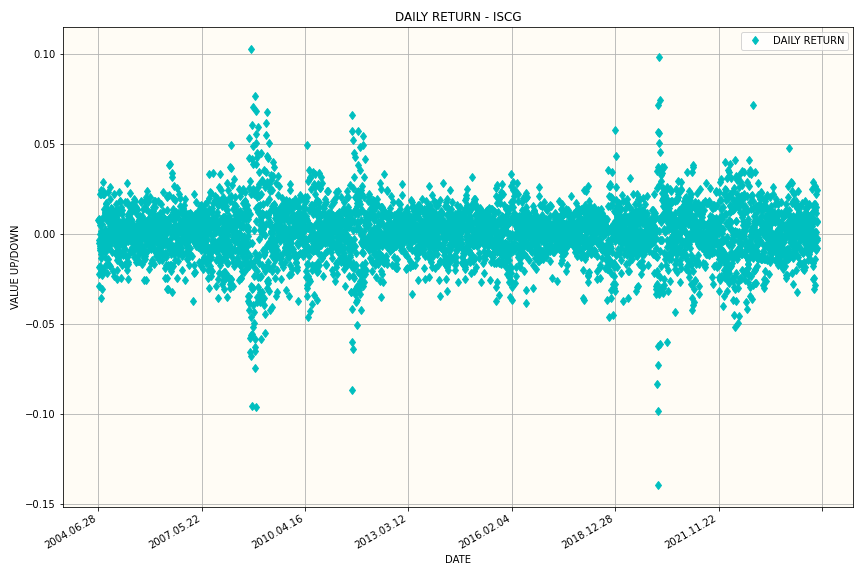

### Generación de Gráficos de Volatilidades

Los datos generados se guardarán en la ruta de *Data/DataWarehouse/Images/Analytics/...-dailyvolatilities*, por cada ETF.

En este caso se pueden generar con los momentos en cada gráfica:

In [ ]:
daily_vol_mom[`IJS]

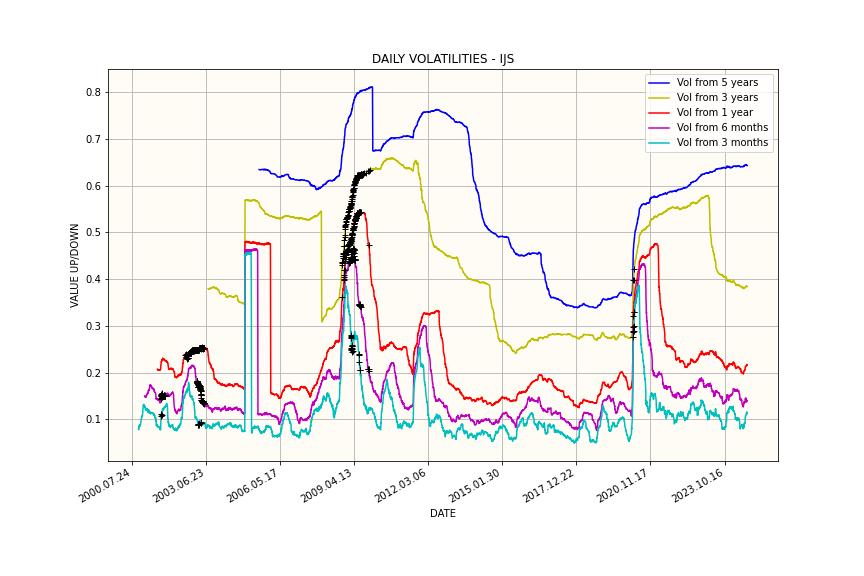

Sin los momentos:

In [ ]:
daily_vol[`IJS]

In [ ]:
{daily_vol[x]} each etfs;

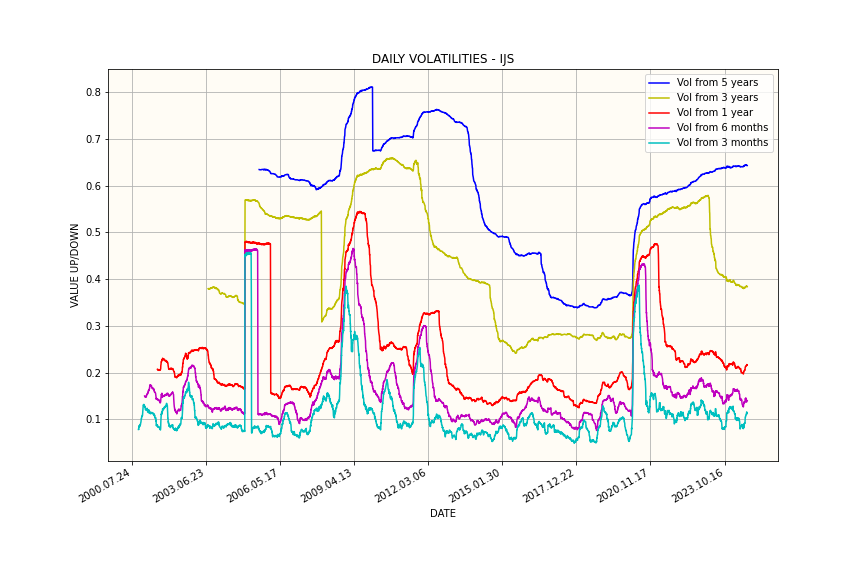

### Generación de Históricos con Momentos Relevantes

Ahora, generaremos los gráficos que más información va a contenter y más nos servirá en el análisis gráfico de nuestro análisis técnico sobre este conjunto de ETFs.

Como hemos indicado antes, los momentos tienen ese ± 25% a un tiempo determinado y que se encuentre por debajo/encima del al SMA mensual, nos servirá mejor de señal para comprar/vender.

Usaremos un diccionario con una tupla (es una lista por ello usamos el *first* y *last*) que nos permita guardar la lista de ETF, así como la ruta a la que deseamos guardar esos gráficos generados de ese ETFs. Según al grupo que pertenece se guarda en:
<div style="text-align: center;">
    <strong>Data/DataWarehouse/Images/Analytics/<span style="color: red;">RUTA</span>/<span style="color: cyan;">ETF</span> - moments X Tiempo</strong>
</div>


In [ ]:
equityClassMap: `large_cap_etf`largemid_cap_etf`mid_cap_etf`small_cap_etf`all_cap_etf 
    ! ((large_cap_etf; "LargeCap");
       (largemid_cap_etf; "LargeMidCap");
       (mid_cap_etf; "MidCap");
       (small_cap_etf; "SmallCap");
       (all_cap_etf; "AllCap"));
val_equity: key equityClassMap;

In [ ]:
{   
    tickers: first equityClassMap x;
    route: last equityClassMap x;
    { 
          hist_filter_msma_5y[y; x];
          hist_filter_msma_3y[y; x];
          hist_filter_msma_1y[y; x];
          hist_filter_msma_6m[y; x];
          hist_filter_msma_3m[y; x];
     }[route] each tickers;
 } each val_equity;

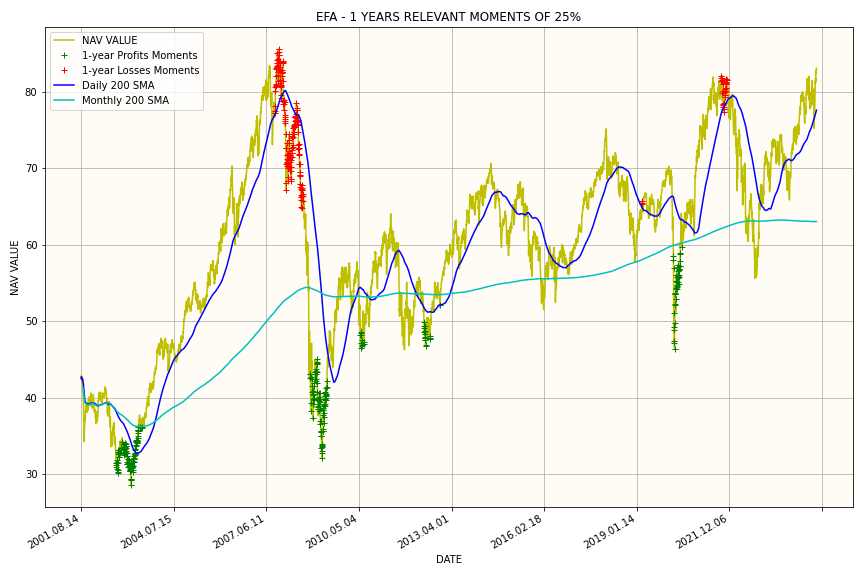

## Generación de Tablas de Métricas y Valores

### Guardado de Tablas

In [ ]:
`:Data/DataWarehouse/Tables/AnalyticsTables/losses25 set table_losses
`:Data/DataWarehouse/Tables/AnalyticsTables/profits25 set table_profits

### Generación de Drawdowns

In [ ]:
drawdowns: ([ticker:`$(); elem:`$()] loss_profit:`$(); max_d5y:`float$(); min_d5y:`float$(); avg_d5y:`float$();
            max_d3y:`float$(); min_d3y:`float$(); avg_d3y:`float$());

drawdownsP: select loss_profit: `profit, max_d5y:max drawdown5y, min_d5y:min drawdown5y, avg_d5y:avg drawdown5y,
        max_d3y:max drawdown3y, min_d3y:min drawdown3y, avg_dy3:avg drawdown3y
        by ticker, elem from table_profits where elem in (`p5y; `p3y);

drawdownsL: select loss_profit: `loss, max_d5y:max drawdown5y, min_d5y:min drawdown5y, avg_d5y:avg drawdown5y,
        max_d3y:max drawdown3y, min_d3y:min drawdown3y, avg_dy3:avg drawdown3y
        by ticker, elem from table_losses where elem in (`p5y; `p3y);

// La tabla se rellena uniendo las dos tablas, forzando estas a ser unkeyed
drawdowns: (0!drawdownsP), (0!drawdownsL);
drawdowns: `ticker xasc drawdowns;


Los datos generados pueden ser mostrados, pero para su posible uso en otros trabajos, pasamos esos datos a *CSV* desde donde poder cogerlos de una manera más correcta y completa. 

In [ ]:
large_caps: select from drawdowns where ticker in large_cap_etf;
large_mid_caps: select from drawdowns where ticker in largemid_cap_etf;
mid_caps: select from drawdowns where ticker in mid_cap_etf;
small_caps: select from drawdowns where ticker in small_cap_etf;
all_caps: select from drawdowns where ticker in all_cap_etf;

save `:Data/DataWarehouse/Drawdowns/large_caps.csv;
save `:Data/DataWarehouse/Drawdowns/large_mid_caps.csv;
save `:Data/DataWarehouse/Drawdowns/mid_caps.csv;
save `:Data/DataWarehouse/Drawdowns/small_caps.csv;
save `:Data/DataWarehouse/Drawdowns/all_caps.csv;

### Generación de Volatilidades

En nuestro caso sólo hemos usado el largo plazo de los 5 y 3 años al considerar datos suficientes para sacar en claro en el l/p el comportamiento, considerando la menor concentración de *ruido*.

La idea es generar tablas que contengan el nº y % de la distribución de las volatilidades en los momentos relevantes del 25%. Esto nos puede dar una idea de como se ha comportado el ETF en el pasado (el tiempo específico en cada caso) en los puntos clave a rendimiento futuro.


#### Volatilidades a 5 años

In [ ]:
res_vol5y_prof: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

res_vol5y_loss: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

In [ ]:
{
    a1: select ticker, vol5y from table_profits where ticker=x, elem in (`p5y);
    a2: select Q1_5yV, Q2_5yV, Q3_5yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_5yV;
    Q2: a2[0]`Q2_5yV;
    Q3: a2[0]`Q3_5yV;

    counts: select ticker, less_Q1: count vol5y where vol5y < Q1, bet_Q1_Q2: count vol5y where Q1 <= vol5y < Q2,
        bet_Q2_Q3: count vol5y where Q2 <= vol5y < Q3, greater_Q3: count vol5y where vol5y >= Q3
        from a1;
    res_vol5y_prof: upsert[`res_vol5y_prof; (counts)];
 } each etfs;

{
    a1: select ticker, vol5y from table_losses where ticker=x, elem in (`p5y);
    a2: select Q1_5yV, Q2_5yV, Q3_5yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_5yV;
    Q2: a2[0]`Q2_5yV;
    Q3: a2[0]`Q3_5yV;
    
    counts: select ticker, less_Q1: count vol5y where vol5y < Q1, bet_Q1_Q2: count vol5y where Q1 <= vol5y < Q2,
        bet_Q2_Q3: count vol5y where Q2 <= vol5y < Q3, greater_Q3: count vol5y where vol5y >= Q3
        from a1;

    res_vol5y_loss: upsert[`res_vol5y_loss; (counts)];
 } each etfs;

In [ ]:
// Calcular los Totales y Porcentajes
res_vol5y_prof: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol5y_prof;
res_vol5y_loss: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol5y_loss;

res_vol5y_prof: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
   from res_vol5y_prof;

res_vol5y_loss: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
      bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
   from res_vol5y_loss;

In [ ]:
large_cap_5y_loss: select from res_vol5y_loss where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_5y_loss.csv;
large_cap_5y_prof: select from res_vol5y_prof where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_5y_prof.csv;
largemid_cap_5y_loss: select from res_vol5y_loss where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_5y_loss.csv;
largemid_cap_5y_prof: select from res_vol5y_prof where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_5y_prof.csv;
mid_cap_5y_loss: select from res_vol5y_loss where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_5y_loss.csv;
mid_cap_5y_prof: select from res_vol5y_prof where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_5y_prof.csv;
small_cap_5y_loss: select from res_vol5y_loss where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_5y_loss.csv;
small_cap_5y_prof: select from res_vol5y_prof where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_5y_prof.csv;
all_cap_5y_loss: select from res_vol5y_loss where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_5y_loss.csv;
all_cap_5y_prof: select from res_vol5y_prof where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_5y_prof.csv;

#### Volatilidades a 3 años

In [ ]:
res_vol3y_prof: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

res_vol3y_loss: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

In [ ]:
{
    a1: select ticker, vol3y from table_profits where ticker=x, elem in (`p3y);
    a2: select Q1_3yV, Q2_3yV, Q3_3yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_3yV;
    Q2: a2[0]`Q2_3yV;
    Q3: a2[0]`Q3_3yV;
    
    counts: select ticker, less_Q1: count vol3y where vol3y < Q1, bet_Q1_Q2: count vol3y where Q1 <= vol3y < Q2,
        bet_Q2_Q3: count vol3y where Q2 <= vol3y < Q3, greater_Q3: count vol3y where vol3y >= Q3
        from a1;
    res_vol3y_prof: upsert[`res_vol3y_prof; (counts)];
 } each etfs;


{
    a1: select ticker, vol3y from table_losses where ticker=x, elem in (`p3y);
    a2: select Q1_3yV, Q2_3yV, Q3_3yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_3yV;
    Q2: a2[0]`Q2_3yV;
    Q3: a2[0]`Q3_3yV;
    
    counts: select ticker, less_Q1: count vol3y where vol3y < Q1, bet_Q1_Q2: count vol3y where Q1 <= vol3y < Q2,
        bet_Q2_Q3: count vol3y where Q2 <= vol3y < Q3, greater_Q3: count vol3y where vol3y >= Q3
        from a1;
    res_vol3y_loss: upsert[`res_vol3y_loss; (counts)];
 } each etfs;

In [ ]:
// Calcular los Totales y Porcentajes
res_vol3y_prof: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol3y_prof;
res_vol3y_loss: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol3y_loss;

res_vol3y_prof: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol3y_prof;


res_vol3y_loss: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol3y_loss;

In [ ]:
largemid_cap_3y_loss: select from res_vol3y_loss where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_3y_loss.csv;
largemid_cap_3y_prof: select from res_vol3y_prof where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_3y_prof.csv;
large_cap_3y_loss: select from res_vol3y_loss where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_3y_loss.csv;
large_cap_3y_prof: select from res_vol3y_prof where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_3y_prof.csv;
mid_cap_3y_loss: select from res_vol3y_loss where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_3y_loss.csv;
mid_cap_3y_prof: select from res_vol3y_prof where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_3y_prof.csv;
small_cap_3y_loss: select from res_vol3y_loss where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_3y_loss.csv;
small_cap_3y_prof: select from res_vol3y_prof where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_3y_prof.csv;
all_cap_3y_loss: select from res_vol3y_loss where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_3y_loss.csv;
all_cap_3y_prof: select from res_vol3y_prof where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_3y_prof.csv;

#### Volatilidades a 1 año

In [ ]:
res_vol1y_prof: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

res_vol1y_loss: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

In [ ]:
{
    a1: select ticker, vol1y from table_profits where ticker=x, elem in (`p1y);
    a2: select Q1_1yV, Q2_1yV, Q3_1yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_1yV;
    Q2: a2[0]`Q2_1yV;
    Q3: a2[0]`Q3_1yV;
    
    counts: select ticker, less_Q1: count vol1y where vol1y < Q1, bet_Q1_Q2: count vol1y where Q1 <= vol1y < Q2,
        bet_Q2_Q3: count vol1y where Q2 <= vol1y < Q3, greater_Q3: count vol1y where vol1y >= Q3
        from a1;
    res_vol1y_prof: upsert[`res_vol1y_prof; (counts)];
 } each etfs;


{
    a1: select ticker, vol1y from table_losses where ticker=x, elem in (`p1y);
    a2: select Q1_1yV, Q2_1yV, Q3_1yV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_1yV;
    Q2: a2[0]`Q2_1yV;
    Q3: a2[0]`Q3_1yV;
    
    counts: select ticker, less_Q1: count vol1y where vol1y < Q1, bet_Q1_Q2: count vol1y where Q1 <= vol1y < Q2,
        bet_Q2_Q3: count vol1y where Q2 <= vol1y < Q3, greater_Q3: count vol1y where vol1y >= Q3
        from a1;
    res_vol1y_loss: upsert[`res_vol1y_loss; (counts)];
 } each etfs;

In [ ]:
// Calcular los Totales y Porcentajes
res_vol1y_prof: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol1y_prof;
res_vol1y_loss: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol1y_loss;

res_vol1y_prof: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol1y_prof;


res_vol1y_loss: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol1y_loss;

In [ ]:
largemid_cap_1y_loss: select from res_vol1y_loss where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_1y_loss.csv;
largemid_cap_1y_prof: select from res_vol1y_prof where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_1y_prof.csv;
large_cap_1y_loss: select from res_vol1y_loss where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_1y_loss.csv;
large_cap_1y_prof: select from res_vol1y_prof where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_1y_prof.csv;
mid_cap_1y_loss: select from res_vol1y_loss where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_1y_loss.csv;
mid_cap_1y_prof: select from res_vol1y_prof where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_1y_prof.csv;
small_cap_1y_loss: select from res_vol1y_loss where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_1y_loss.csv;
small_cap_1y_prof: select from res_vol1y_prof where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_1y_prof.csv;
all_cap_1y_loss: select from res_vol1y_loss where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_1y_loss.csv;
all_cap_1y_prof: select from res_vol1y_prof where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_1y_prof.csv;

#### Volatilidades a 6 meses

In [ ]:
res_vol6m_prof: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

res_vol6m_loss: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

In [ ]:
{
    a1: select ticker, vol6m from table_profits where ticker=x, elem in (`p6m);
    a2: select Q1_6mV, Q2_6mV, Q3_6mV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_6mV;
    Q2: a2[0]`Q2_6mV;
    Q3: a2[0]`Q3_6mV;
    
    counts: select ticker, less_Q1: count vol6m where vol6m < Q1, bet_Q1_Q2: count vol6m where Q1 <= vol6m < Q2,
        bet_Q2_Q3: count vol6m where Q2 <= vol6m < Q3, greater_Q3: count vol6m where vol6m >= Q3
        from a1;
    res_vol6m_prof: upsert[`res_vol6m_prof; (counts)];
 } each etfs;


{
    a1: select ticker, vol6m from table_losses where ticker=x, elem in (`p6m);
    a2: select Q1_6mV, Q2_6mV, Q3_6mV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_6mV;
    Q2: a2[0]`Q2_6mV;
    Q3: a2[0]`Q3_6mV;
    
    counts: select ticker, less_Q1: count vol6m where vol6m < Q1, bet_Q1_Q2: count vol6m where Q1 <= vol6m < Q2,
        bet_Q2_Q3: count vol6m where Q2 <= vol6m < Q3, greater_Q3: count vol6m where vol6m >= Q3
        from a1;
    res_vol6m_loss: upsert[`res_vol6m_loss; (counts)];
 } each etfs;

In [ ]:
// Calcular los Totales y Porcentajes
res_vol6m_prof: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol6m_prof;
res_vol6m_loss: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol6m_loss;

res_vol6m_prof: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol6m_prof;


res_vol6m_loss: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol6m_loss;

In [ ]:
large_cap_6m_loss: select from res_vol6m_loss where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_6m_loss.csv;
large_cap_6m_prof: select from res_vol6m_prof where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_6m_prof.csv;
largemid_cap_6m_prof: select from res_vol6m_prof where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_6m_prof.csv;
largemid_cap_6m_loss: select from res_vol6m_loss where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_6m_loss.csv;
mid_cap_6m_loss: select from res_vol6m_loss where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_6m_loss.csv;
mid_cap_6m_prof: select from res_vol6m_prof where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_6m_prof.csv;
small_cap_6m_loss: select from res_vol6m_loss where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_6m_loss.csv;
small_cap_6m_prof: select from res_vol6m_prof where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_6m_prof.csv;
all_cap_6m_loss: select from res_vol6m_loss where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_6m_loss.csv;
all_cap_6m_prof: select from res_vol6m_prof where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_6m_prof.csv;

#### Volatilidades a 3 meses

In [ ]:
res_vol3m_prof: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

res_vol3m_loss: ([ticker:`$()] less_Q1:`int$(); less_Q1_pct:`float$(); bet_Q1_Q2:`int$();
                bet_Q1_Q2_pct:`float$(); bet_Q2_Q3:`int$(); bet_Q2_Q3_pct:`float$();
                greater_Q3:`int$(); greater_Q3_pct:`float$(); total:`int$());

In [ ]:
{
    a1: select ticker, vol3m from table_profits where ticker=x, elem in (`p3m);
    a2: select Q1_3mV, Q2_3mV, Q3_3mV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_3mV;
    Q2: a2[0]`Q2_3mV;
    Q3: a2[0]`Q3_3mV;
    
    counts: select ticker, less_Q1: count vol3m where vol3m < Q1, bet_Q1_Q2: count vol3m where Q1 <= vol3m < Q2,
        bet_Q2_Q3: count vol3m where Q2 <= vol3m < Q3, greater_Q3: count vol3m where vol3m >= Q3
        from a1;
    res_vol3m_prof: upsert[`res_vol3m_prof; (counts)];
 } each etfs;


{
    a1: select ticker, vol3m from table_losses where ticker=x, elem in (`p6m);
    a2: select Q1_3mV, Q2_3mV, Q3_3mV from resume_etf where ticker=x;

    // Obtener los valores límites de los Cuartiles
    Q1: a2[0]`Q1_3mV;
    Q2: a2[0]`Q2_3mV;
    Q3: a2[0]`Q3_3mV;
    
    counts: select ticker, less_Q1: count vol3m where vol3m < Q1, bet_Q1_Q2: count vol3m where Q1 <= vol3m < Q2,
        bet_Q2_Q3: count vol3m where Q2 <= vol3m < Q3, greater_Q3: count vol3m where vol3m >= Q3
        from a1;
    res_vol3m_loss: upsert[`res_vol3m_loss; (counts)];
 } each etfs;

In [ ]:
// Calcular los Totales y Porcentajes
res_vol3m_prof: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol3m_prof;
res_vol3m_loss: update total: sum (less_Q1; bet_Q1_Q2; bet_Q2_Q3; greater_Q3) from res_vol3m_loss;

res_vol3m_prof: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol3m_prof;


res_vol3m_loss: update less_Q1_pct: (less_Q1 % total), bet_Q1_Q2_pct: (bet_Q1_Q2 % total),
        bet_Q2_Q3_pct: (bet_Q2_Q3 % total), greater_Q3_pct: (greater_Q3 % total)
    from res_vol3m_loss;

In [ ]:
large_cap_3m_prof: select from res_vol3m_prof where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_3m_prof.csv;
large_cap_3m_loss: select from res_vol3m_loss where ticker in large_cap_etf
save `:Data/DataWarehouse/Volatilities/large_cap_3m_loss.csv;
largemid_cap_3m_loss: select from res_vol3m_loss where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_3m_loss.csv;
largemid_cap_3m_prof: select from res_vol3m_prof where ticker in largemid_cap_etf
save `:Data/DataWarehouse/Volatilities/largemid_cap_3m_prof.csv;
mid_cap_3m_loss: select from res_vol3m_loss where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_3m_loss.csv;
mid_cap_3m_prof: select from res_vol3m_prof where ticker in mid_cap_etf
save `:Data/DataWarehouse/Volatilities/mid_cap_3m_prof.csv;
small_cap_3m_loss: select from res_vol3m_loss where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_3m_loss.csv;
small_cap_3m_prof: select from res_vol3m_prof where ticker in small_cap_etf
save `:Data/DataWarehouse/Volatilities/small_cap_3m_prof.csv;
all_cap_3m_loss: select from res_vol3m_loss where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_3m_loss.csv;
all_cap_3m_prof: select from res_vol6m_prof where ticker in all_cap_etf
save `:Data/DataWarehouse/Volatilities/all_cap_3m_prof.csv;

# Extras

In [ ]:
{hist_lp_relev[x];hist_cp_relev[x];daily_vol[x];daily_ret[x]} each large_cap_etf;
{hist_lp_relev[x];hist_cp_relev[x];daily_vol[x];daily_ret[x]} each largemid_cap_etf;
{hist_lp_relev[x];hist_cp_relev[x];daily_vol[x];daily_ret[x]} each mid_cap_etf;
{hist_lp_relev[x];hist_cp_relev[x];daily_vol[x];daily_ret[x]} each small_cap_etf;
{hist_lp_relev[x];hist_cp_relev[x];daily_vol[x];daily_ret[x]} each all_cap_etf;